# **Simon's Algorithm**
#### Simon's algorithm was the first quantum algorithm to demonstrate an exponential speedup over classical algorithms. This algorithm showed that a quantum computer could solve the problem using $O(n)$ oracle queries, whereas any classical algorithm would require $O(2^{n/2})$ queries.
#### Given an unknown function with $n$ binary inputs and $n$ binary outputs, $f:\{0,1\}^n \rightarrow \{0,1\}^n$, with the following properties:

- There is an unknown string $s \in\{0,1\}^n$ such that for any two distinct inputs $x$ and $x^\prime$, $f(x) = f(x^\prime)$ if and only if $x\oplus x^\prime = s$ where $\oplus$ denotes the XOR operation.
- In other words, $f(x)$ is a 2-to-1 function: every output is produced by exactly two distinct inputs, which are related by XOR with the hidden string $s$

#### The goal is to determine the hidden string $s$.

In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

#### The following steps show the formation of the Simon's algorithm.

## **Step 1:** Initialize the qubits
#### We prepare the initial state as both input and output qubits are in state $|0\rangle$:
$$
|\phi_1\rangle =|0\rangle^{\otimes n} |0\rangle^{\otimes n}.
$$

## **Step 2:** Apply Hadamard gates
#### We apply the Hadamard gate to each input qubit, putting all $n$ input qubits into a superposition of all possible states.
$$
|\phi_2\rangle = |0\rangle^{\otimes n} \otimes \left(H^{\otimes n}|0\rangle^{\otimes n}\right)\nonumber\\
=\frac{1}{\sqrt{2^n}} |0\rangle^{\otimes n}\sum_{x =0}^{2^n-1} |x\rangle .
$$
#### where $x$ is an integer encoded in binary. For example, $x \in\{0,1,2,3\}$ for $n=2$ where in the binary basis they represent $\{0\rightarrow |00\rangle,1\rightarrow |01\rangle,2\rightarrow |10\rangle,3\rightarrow |11\rangle\}$ in big endian format.

## **Step 3:** Apply the oracle
#### The oracle is a black-box quantum function that implements the given function $f$. It maps the input $x$ to the output $f(x)$. This transforms the state to 
$$
U_f|y,x\rangle = |y \oplus f(x), x\rangle
$$
#### where $x$ is the first $n$ qubit and also input of $f(x)$, $y$ is the output qubit and $\oplus$ is the $XOR$ operation. Since $|y\rangle =|0\rangle^{\otimes n}$ then $|y \oplus f(x)\rangle = |f(x)\rangle$. The oracle $U_f$ is applied to all the $n$-qubits with state $|x\rangle$
$$
|\phi_3\rangle = U_f|\phi_2\rangle \nonumber\\
= \frac{1}{\sqrt{2^n}}  \sum_{x =0}^{2^n-1}  |f(x)\rangle|x\rangle .
$$


## **Step 4:** Apply Hadamard gates on the $n$-qubits input

#### After applying the oracle, we apply the Hadamard gate to all input qubits to bring them back from superposition. This creates quantum interference.
$$
|\phi_4\rangle = I^{\otimes n}\otimes H^{\otimes n}|\phi_3\rangle \nonumber\\
= \frac{1}{2^n}  \sum_{z\in \{0,1\}} \sum_{x \in \{0,1\}} (-1)^{x.z}|f(x)\rangle|z\rangle ,
$$
#### where $x.z$ is the bitwise dot product modulo 2 between the strings $x$ and $z$:
$$
x.z = x_1z_1 \oplus x_2z_2 \oplus x_3z_3 \oplus .... \oplus x_nz_n.
$$

#### Because $f(x) = f(x\oplus s)$ pairs of inputs $x$ and $x\oplus s$ lead to interference in the sum over $x$. For each $z$, the contribution from $xe$ and $x\oplus s$ is:
$$
(-1)^{x.z} + (-1)^{(x\oplus s).z}
$$
#### Using the linearity, we have $(x\oplus s).z = x.z \oplus s.z$
- If $s.z = 0$, the interference is constructive which leads to amplitude 1. 
- If $s.z = 1$, the two terms cancel out due to destructive interference.

## **Step 5:** Measurement:
#### Finally, we measure the input $n$ qubits. The result of the measurement will give us the $z$ (orthogonal to bit string $s$). Eventually, using linear equation $z.s = 0$ we will find the bit string $s$.

In [8]:
# secret string
s = '10'

input_qubits = len(str(s))

total_qubits = 2 * input_qubits

# Step 1: Initialise the circuit
qc = QuantumCircuit(total_qubits , input_qubits)

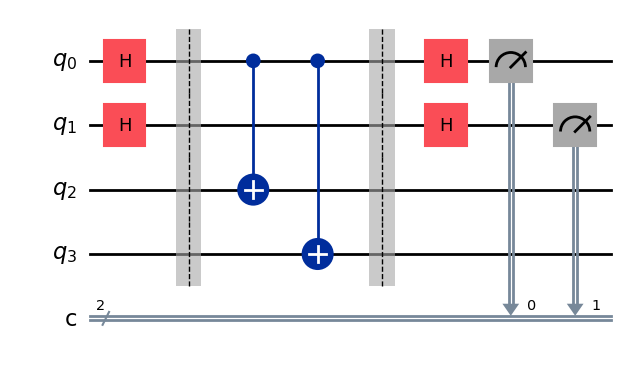

In [9]:
# Step 2: apply hadamard gate to the input qubits
qc.h(range(input_qubits))
qc.barrier()

# Step 3: Apply the oracle
for idx in range(input_qubits):
    if s[idx] == '1':
        for count in range(input_qubits):
            qc.cx(idx , input_qubits + count)

qc.barrier()

# Step 4: apply hadamard gate to the input qubits
qc.h(range(input_qubits))

# Step 5
qc.measure([0,1] , [0,1])

qc.draw('mpl')


 Total counts are: {'00': 527, '01': 473}


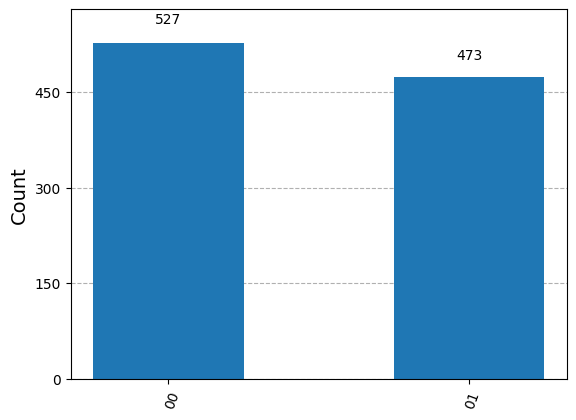

In [10]:
# initiate
estimator = Aer.get_backend('qasm_simulator')

#run
job = estimator.run(qc, shots = 1000)

# result
counts = job.result().get_counts(qc)

print("\n Total counts are:" , counts)

plot_histogram(counts)

#### When we have $s = 01$, the bitwise product condition $z.s = 0$ results:
$$
z_1 . 0 \oplus z_2 . 1 = 0.
$$
#### In two cases, $z_1 = 0, z_2 = 0$ and $z_1 = 1, z_2 = 0$ the above condition is satisfied.  This explains why we observe two outcomes in the histogram."